This project utilizes Transformer-based encoders to classify tweet sentiment as positive or negative. 

It utilizes the Sentiment140 dataset http://help.sentiment140.com/for-students. For this project I only used the train.csv data. I split a subset of the data into train and test data.

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

%matplotlib inline

### EDA and Data preparation

In [2]:
DIR = "drive/MyDrive/Colab Notebooks/Projects/NLP Tweets/"

In [3]:
colnames = ['label', 'time', 'date', 'query', 'username', 'text']

In [6]:
df = pd.read_csv(DIR + "training.csv", names=colnames, encoding='latin-1')

In [7]:
df.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


Drop some irrelevant columns. For this project I only consider the tweet text to make the classifications.

In [8]:
data = df.drop(columns=['time', 'date', 'query', 'username'])

Update the label value of 4 (positive) to 1, so the two labels are 0 (negative) and 1 (positive).

In [9]:
data.loc[data['label']==4, 'label'] = 1

In [10]:
data.label.value_counts()

0    800000
1    800000
Name: label, dtype: int64

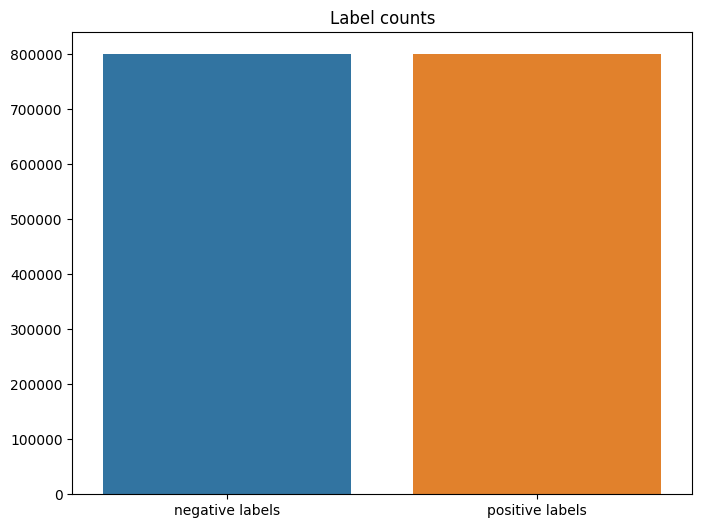

In [11]:
negative_count = len(data[data.label==0])
positive_count = len(data[data.label==1])

plt.figure(figsize=(8, 6))
sns.barplot(x=['negative labels', 'positive labels'], y=[negative_count, positive_count])
plt.title('Label counts')
plt.show()

In [12]:
negative_examples = data[data.label==0]

for i in range(10000, 10010):
  print(str(i) + ": " + negative_examples.iloc[i].text)

10000: I think there's a problem with the ISP in this area or something...my connection go too slow to do anything online yesterday &amp; today 
10001: @ nawong How do I go about getting access to idzr.org I'm dying to try it out 
10002: @ nawong How do I go about getting access to idzr.org I'm dying to try it out 
10003: Talking to designers...I can't squeeze any design juice from my brain...for my personal website. 
10004: Rainy day 
10005: completely failed to upload my cute picture. Format too big 
10006: Hrm, scanner traffic diminishes greatly when your public services are on strike. 
10007: doesnt have 1 single pair of spring pants that fit 
10008: tired of swollen hands...they don't feel good. 
10009: goodmorning!&lt;3 wishing the sun would come through the clouds  i can tell this is going to be one of those days..... 


In [13]:
positive_examples = data[data.label==1]

for i in range(10000, 10010):
  print(str(i) + ": " + positive_examples.iloc[i].text)

10000: Have a gig in Northampton at the racehorse tmw night 
10001: Slept in for an extra 30  in Alviso http://loopt.us/uLUVfA
10002: @chickbot Kinda like status updates 
10003: 99 thieving last night 
10004: off to SAT prep 
10005: OMG and i thought my monster yesterday was amazing! Boy was i wrong! THERE'S CARMALLOWS IN THE CABINET!! 
10006: Good morning twitter 
10007: @reannatugiri Thanks!  That just made my day. 
10008: Just discovered that @BorrowLenses is on Twitter! NAPP members get a discount! 
10009: Heading to the gym- have to work off the ice cream from yesterday. 


In [14]:
from wordcloud import STOPWORDS

print(STOPWORDS)

{"you'd", "we'll", "we'd", "isn't", 'down', 'could', 'her', "that's", 'under', "who's", 'my', 'also', "mustn't", "i'll", 'i', "we're", "wouldn't", 'more', "he'd", 'was', "let's", "wasn't", "hadn't", 'it', 'she', 'some', "i'm", 'an', "i'd", 'having', 'itself', 'http', 'there', 'with', "hasn't", 'or', 'were', 'few', 'hence', "didn't", 'else', 'his', 'the', "how's", 'from', 'otherwise', 'yourself', 'their', 'yourselves', 'after', 'above', 'each', "you've", 'its', 'since', 'this', 'yours', 'such', 'a', 'am', 'get', 'through', 'who', 'most', 'than', 'myself', 'be', 'against', "there's", 'to', 'because', 'would', "she'll", 'not', 'about', "you're", "weren't", "he'll", 'com', 'only', "couldn't", 'doing', 'www', 'do', 'does', 'by', "they're", 'into', 'in', "won't", 'while', 'during', 'them', "what's", 'out', 'r', 'whom', "when's", "they've", 'can', 'are', 'been', 'below', "can't", 'as', 'own', 'did', "shouldn't", 'very', 'our', "she'd", "they'd", "doesn't", 'so', 'theirs', 'him', 'nor', 'he', 

In [15]:
def split_text(text):
  tokens = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
  return tokens

In [16]:
from collections import defaultdict

Count how many times words appear in the tweets.

In [17]:
negative_words = defaultdict()
positive_words = defaultdict()

NEGATIVE = data['label'] == 0

for text in data[NEGATIVE]['text']:
  for word in split_text(text):
    if word not in negative_words:
      negative_words[word] = 0
    negative_words[word] += 1

for text in data[~NEGATIVE]['text']:
  for word in split_text(text):
    if word not in positive_words:
      positive_words[word] = 0
    positive_words[word] += 1

In [18]:
negative_words_df = pd.DataFrame(sorted(negative_words.items(), key=lambda x: x[1])[::-1])
positive_words_df = pd.DataFrame(sorted(positive_words.items(), key=lambda x: x[1])[::-1])

In [19]:
negative_words_df.columns = ['word', 'count']
positive_words_df.columns = ['word', 'count']

In [20]:
negative_words_df.tail()

,word,count
650349,",only",1
650350,@loltrish,1
650351,@kwesidei,1
650352,@nationwideclass,1
650353,http://twitpic.com/2y1zl,1


In [21]:
positive_words_df.tail()

,word,count
765902,@e4voip,1
765903,acm's?!,1
765904,sulk!,1
765905,@productoffear,1
765906,sunisa!,1


Top word counts by label

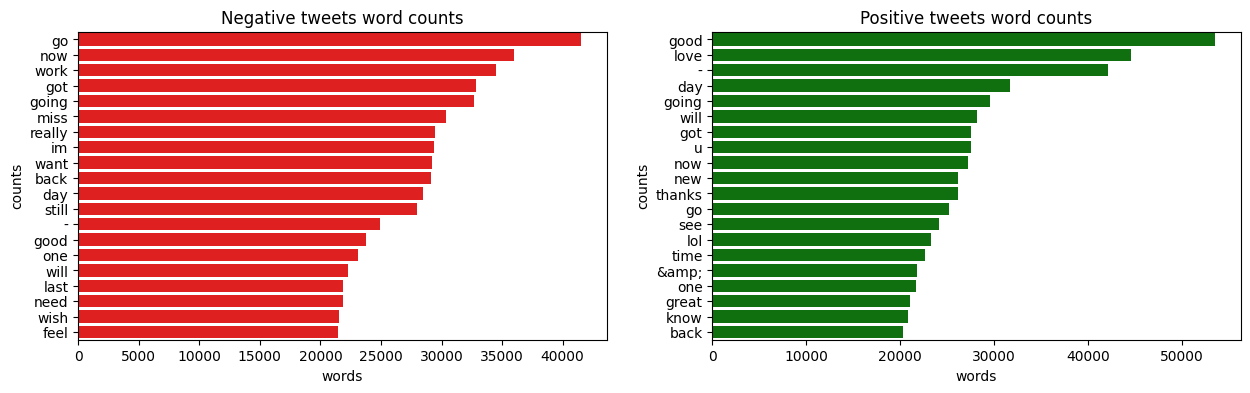

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

sns.barplot(y=negative_words_df['word'].values[:20], x=negative_words_df['count'].values[:20], color='red', ax=axs[0])
axs[0].set_title('Negative tweets word counts')
axs[0].set_xlabel('words')
axs[0].set_ylabel('counts')

sns.barplot(y=positive_words_df['word'].values[:20], x=positive_words_df['count'].values[:20], color='green', ax=axs[1])
axs[1].set_title('Positive tweets word counts')
axs[1].set_xlabel('words')
axs[1].set_ylabel('counts')

plt.show()

In [23]:
data_copy = data.copy()

In [24]:
data_copy['char_count'] = data_copy['text'].apply(lambda x: len(str(x)))
data_copy['word_count'] = data_copy['text'].apply(lambda x: len(str(x).split()))
data_copy['mean_word_length'] = data_copy['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [25]:
data_copy.head()

,label,text,char_count,word_count,mean_word_length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115,19,5.052632
1,0,is upset that he can't update his Facebook by ...,111,21,4.285714
2,0,@Kenichan I dived many times for the ball. Man...,89,18,3.944444
3,0,my whole body feels itchy and like its on fire,47,10,3.700000
4,0,"@nationwideclass no, it's not behaving at all....",111,21,4.285714


Character counts by tweets

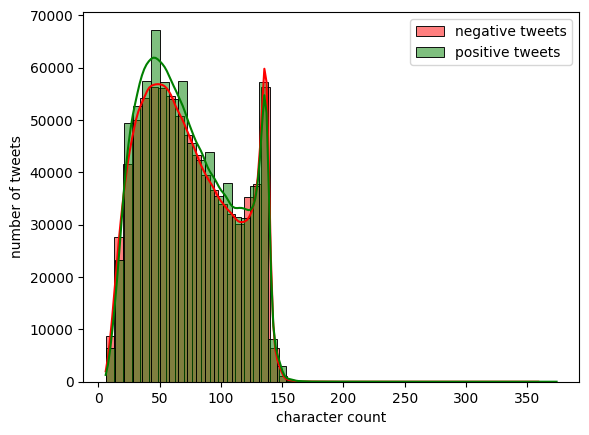

In [26]:
NEGATIVE = data_copy['label'] == 0

sns.histplot(data=data_copy[NEGATIVE], bins=50, x='char_count', label='negative tweets', kde=True, color='red')
sns.histplot(data=data_copy[~NEGATIVE], bins=50, x='char_count', label='positive tweets', kde=True, color='green')

plt.xlabel('character count')
plt.ylabel('number of tweets')
plt.legend()
plt.show()

Word counts by tweets

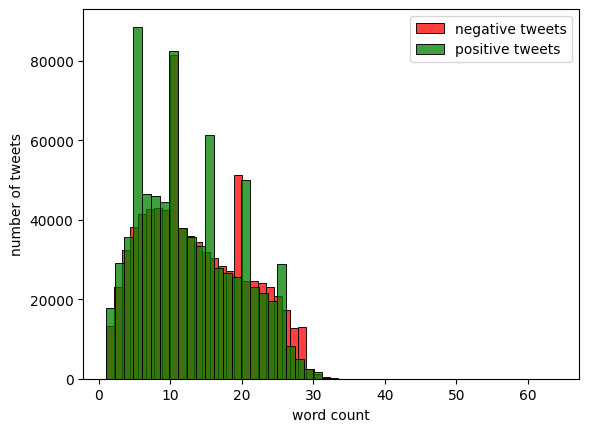

In [27]:
sns.histplot(data=data_copy[NEGATIVE], bins=50, x='word_count', label='negative tweets', color='red')
sns.histplot(data=data_copy[~NEGATIVE], bins=50, x='word_count', label='positive tweets', color='green')

plt.xlabel('word count')
plt.ylabel('number of tweets')
plt.legend()
plt.show()

Mean word lengths by tweets

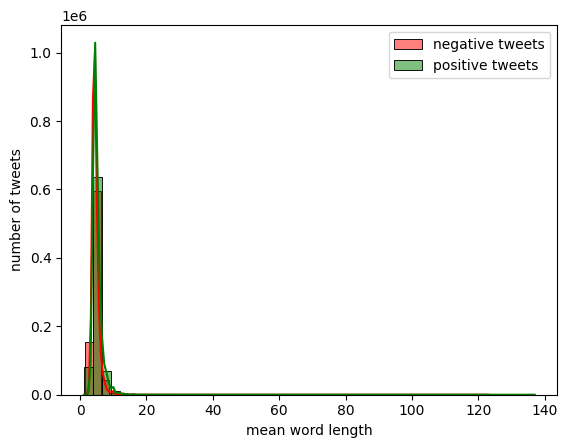

In [28]:
sns.histplot(data=data_copy[NEGATIVE], bins=50, x='mean_word_length', label='negative tweets', kde=True, color='red')
sns.histplot(data=data_copy[~NEGATIVE], bins=50, x='mean_word_length', label='positive tweets', kde=True, color='green')

plt.xlabel('mean word length')
plt.ylabel('number of tweets')
plt.legend()
plt.show()

Preprocess the text

In [29]:
# Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [30]:
# Thanks to https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
wnl = WordNetLemmatizer()

In [33]:
# Thanks to https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-for-beginners
# for some ideas.

# Replace URLs with 'URL' (http/https/www)
def replace_urls(text):
  return re.sub(r'((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)', 'URL', text)

def remove_urls(text):
  return re.sub(r'((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)', '', text)

# Replace @username with USER
def replace_usernames(text):
  return re.sub(r'@[^\s]+', 'USER', text)

def remove_usernames(text):
  return re.sub(r'@[^\s]+', '', text)

# Replace abbreviations (ftw -> for the win)
def replace_abbr(text):
  texts = []
  for word in text.split(" "):
    if word in abbreviations:
      texts.append(abbreviations[word])
    else:
      texts.append(word)
  return " ".join(texts)

# Replace emojis with words
def replace_emojis(text):
  texts = []
  for word in text.split(" "):
    if word in emojis:
      texts.append(emojis[word])
    else:
      texts.append(word)
  return " ".join(texts)

# Remove stop words
stopwords_set = set(stopwords.words("english"))
def remove_stop_words(text):
  text_list = [w for w in text.split(" ") if ((w not in stopwords_set) and (not w.strip() == ""))]
  return " ".join(text_list)

# Remove non-alphanumeric characters
def remove_non_alphanum(text):
  return re.sub(r'[^a-zA-Z0-9|\s]', "", text)

# Remove repeating characters (3+ repeating letters with 2 letters)
def remove_repeating_chars(text):
  text = re.sub(r'(.)\1\1+',r'\1\1', text)
  return text

# Replace numerical characters
def replace_numbers(text):
  return re.sub(r'[0-9]+', 'NUM', text)

def remove_numbers(text):
  return re.sub(r'[0-9]+', '', text)

# Lemmatize
def lemmatize_text(text):
  text_list = [wnl.lemmatize(w) for w in text.split(" ")]
  return " ".join(text_list)

# Remove empty spaces
def remove_empty(text):
  text = [w for w in text.split(" ") if (not w.strip() == "")]
  return " ".join(text)

# Remove words shorter than 2 characters
def remove_short_words(text):
  text = [w for w in text.split(" ") if len(w) > 1]
  return " ".join(text)

In [43]:
def clean_text(text):
  text = text.lower()

  #text = replace_urls(text)
  text = remove_urls(text)
  #text = replace_usernames(text)
  text = remove_usernames(text)
  text = replace_abbr(text)
  text = replace_emojis(text)
  #text = remove_stop_words(text)
  text = remove_non_alphanum(text)
  text = remove_repeating_chars(text)
  #text = replace_numbers(text)
  text = remove_numbers(text)
  #text = lemmatize_text(text)
  text = remove_empty(text)
  #text = remove_short_words(text)

  return text

In [44]:
def clean_df(df, src_col, target_col):
  df_copy = df.copy()
  df_copy[target_col] = df[src_col].astype(str).apply(lambda x:clean_text(x))
  return df_copy

In [47]:
for i in range(10):
  print(data_copy.loc[i].text)
  print(clean_text(data_copy.loc[i].text))
  print()

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
aww thats a bummer you shoulda got david carr of third day to do it wink

is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
is upset that he cant update his facebook by texting it and might cry as a result school today also blah

@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
i dived many times for the ball managed to save the rest go out of bounds

my whole body feels itchy and like its on fire 
my whole body feels itchy and like its on fire

@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
no its not behaving at all im mad why am i here because i cant see you all over there

@Kwesidei not the whole crew 
not the whole crew

Need a hug 
need a hug

@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a

Note: Words like "not" and "no" are stop words, but since they have importance in the meaning of a tweet, I keep the stopwords in the text.

In [48]:
print("no" in STOPWORDS)
print("not" in STOPWORDS)

True
True


Note: The lemmatizer (defaulting pos value as "n") seems to change "was" to "wa", which is not correct. For my approach, I will not apply the lemmatizer.

In [49]:
text = "I am not happy. Wasn't happy. was are am"

print(nltk.word_tokenize(text))
print(clean_text(text))
print(lemmatize_text(" ".join(nltk.word_tokenize(text))))

['I', 'am', 'not', 'happy', '.', 'Was', "n't", 'happy', '.', 'was', 'are', 'am']
i am not happy wasnt happy was are am
I am not happy . Was n't happy . wa are am


Since there are 1.6 million entries, the training will take a long time, especially for the BERT model. I use a subset of the data instead.

In [62]:
ENTRIES = 160000

In [63]:
df_bert_neg = data[data['label']==0][:ENTRIES]
df_bert_pos = data[data['label']==1][:ENTRIES]

# Combine entries
df_bert = pd.concat([df_bert_neg, df_bert_pos])

In [64]:
df_bert['label'].value_counts()

0    160000
1    160000
Name: label, dtype: int64

In [65]:
df_bert = clean_df(df_bert, 'text', 'cleaned_text')

In [67]:
df_bert[:10]

,label,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",aww thats a bummer you shoulda got david carr ...
1,0,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,0,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...
5,0,@Kwesidei not the whole crew,not the whole crew
6,0,Need a hug,need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...,hey long time no see yes rains a bit only a bi...
8,0,@Tatiana_K nope they didn't have it,nope they didnt have it
9,0,@twittera que me muera ?,que me muera


In [68]:
X_clean = df_bert.cleaned_text.values
y_clean = df_bert.label

### Transformer Encoder Model

I use the Encoder block of the Transformer architecture, based on the paper: https://arxiv.org/abs/1706.03762

![image](https://th.bing.com/th/id/OIP.ANp02TCmA6Nw0obCRoBFawAAAA?pid=ImgDet&rs=1)

For this custom model, the inputs will be sequences of tokens with padding to make sure the examples have the same input size.

Tokenize the text

In [69]:
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

In [70]:
tokenizer = Tokenizer()

In [71]:
tokenizer.fit_on_texts(X_clean)

In [72]:
print(tokenizer.texts_to_sequences(X_clean)[0])

[201, 103, 4, 1270, 6, 3791, 50, 660, 8259, 12, 1796, 28, 2, 40, 9, 293]


In [73]:
print(X_clean[0])

aww thats a bummer you shoulda got david carr of third day to do it wink


In [74]:
X = tokenizer.texts_to_sequences(X_clean)

Pad the sequences

In [75]:
max_len=40

In [76]:
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=max_len)

In [77]:
print(X[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0  201  103    4 1270
    6 3791   50  660 8259   12 1796   28    2   40    9  293]


Train-test split

In [78]:
X_train, X_val, y_train, y_val = train_test_split(X, y_clean, test_size=0.2, random_state=42)

In [79]:
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  97, 479,   2,
         6], dtype=int32)

In [81]:
y_train.iloc[0]

0

In [82]:
y_train.value_counts()

1    128066
0    127934
Name: label, dtype: int64

In [83]:
y_val.value_counts()

0    32066
1    31934
Name: label, dtype: int64

In [84]:
X_train.shape, X_val.shape

((256000, 40), (64000, 40))

#### Model architecture

Define some constants

In [86]:
# Max size of vocabulary to consider
vocab_size = len(tokenizer.word_index) + 1

# Embedding dimension for each token
embed_dim = 32 # 512
# Number of attention heads
num_heads = 8 # 8
# Hidden layer size in Feed Forward network
d_ff = 2048
# Number of encoder layers
n_layers = 1

dropout_rate = 0.1

##### Input Embedding and Positional Encoding

Positional encodings are computed as:
- $PE_{(pos, 2i)} = sin(pos/10000^{\frac{2i}{d_{model}}})$

- $PE_{(pos, 2i+1)} = cos(pos/10000^{\frac{2i}{d_{model}}})$

In [87]:
# Thanks to https://www.tensorflow.org/text/tutorials/transformer#the_embedding_and_positional_encoding_layer
class PositionalEmbedding(layers.Layer):
  # num_words = number of words to consider in tweet.
    # Each word index is "pos"
    # Each value "i" is the index of the embeddings which have dimension d_model.
  def __init__(self, num_words, d_model=embed_dim):
    super(PositionalEmbedding, self).__init__()
    self.pos_encodings = self.calculate_pos_encodings(num_words, d_model)

  def calculate_pos_encodings(self, num_words, d_model):
    depth = d_model / 2
    positions = np.arange(num_words)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :] / depth

    angle_rates = 1 / (10000**depths)
    angle_rads = positions * angle_rates

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)
    
    return tf.cast(pos_encoding, dtype=tf.float32)

  def call(self, length):
    return self.pos_encodings[tf.newaxis, :length, :]

In [88]:
class EmbeddingLayer(layers.Layer):
  # num_words = words to consider in tweet
  # d_model = embedding dimension for each token
  # vocab_size = Number of unique tokens
  def __init__(self, num_words, vocab_size, d_model=embed_dim):
    super(EmbeddingLayer, self).__init__()
    self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=d_model)
    #self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=d_model)
    self.pos_emb = PositionalEmbedding(num_words=num_words, d_model=d_model)
    self.num_words = num_words

  def call(self, x):
    num_words = tf.shape(x)[-1]
    #positions = tf.range(start=0, limit=num_words, delta=1)
    #positional_embeddings = self.pos_emb(positions)
    positional_embeddings = self.pos_emb(num_words)
    x = self.token_emb(x)
    return x + positional_embeddings

Encoder block

In [89]:
class FeedForward(layers.Layer):
  def __init__(self, d_model=embed_dim, d_ff=d_ff):
    super(FeedForward, self).__init__()
    self.seq = keras.Sequential([
        layers.Dense(d_ff, activation='relu'),
        layers.Dense(d_model)
    ])

  def call(self, x):
    return self.seq(x)

In [90]:
class EncoderLayer(layers.Layer):
  def __init__(self, num_heads, d_model=embed_dim, d_ff=d_ff, dropout_rate=0.1):
    super(EncoderLayer, self).__init__()
    self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
    self.ffn = FeedForward(d_model, d_ff)
    self.dropout1 = layers.Dropout(dropout_rate)
    self.dropout2 = layers.Dropout(dropout_rate)
    self.layernorm1 = layers.LayerNormalization()
    self.layernorm2 = layers.LayerNormalization()

  def call(self, x, training):
    attn_output = self.attn(x, x)                               # Multi-Head Attention
    attn_output = self.dropout1(attn_output, training=training) # Dropout
    layer1_output = self.layernorm1(x + attn_output)            # Add & Norm

    ffn_output = self.ffn(layer1_output)                        # Feed Forward
    ffn_output = self.dropout2(ffn_output, training=training)   # Dropout
    output = self.layernorm2(layer1_output + ffn_output)        # Add & Norm

    return output

In [91]:
class Encoder(layers.Layer):
  def __init__(self, num_words, n_layers, d_model, num_heads, d_ff, vocab_size,
               dropout_rate=0.1):
    super(Encoder, self).__init__()
    self.num_words = num_words
    self.d_model = d_model
    self.n_layers = n_layers
    self.embedding = EmbeddingLayer(num_words=num_words, d_model=d_model, 
                                    vocab_size=vocab_size)
    self.layers = [
        EncoderLayer(d_model=d_model, d_ff=d_ff, num_heads=num_heads, 
                     dropout_rate=dropout_rate)
        for _ in range(n_layers)]
    self.dropout = layers.Dropout(dropout_rate)

  def call(self, x):
    # Embedding
    x = self.embedding(x)
    x = self.dropout(x)

    # N x Encoder layers
    for i in range(len(self.layers)):
      x = self.layers[i](x)

    return x

In [93]:
encoder_model = keras.Sequential()

encoder_model.add(keras.Input(shape=(max_len,)))
encoder_model.add(EmbeddingLayer(num_words=max_len, vocab_size=vocab_size, 
                          d_model=embed_dim))

encoder_model.add(EncoderLayer(d_model=embed_dim, d_ff=d_ff, num_heads=num_heads, 
                        dropout_rate=dropout_rate))

encoder_model.add(layers.GlobalAveragePooling1D())

encoder_model.add(layers.Dense(256, activation='relu', name='dense-256'))
encoder_model.add(layers.Dropout(dropout_rate, name='Dropout-1'))
encoder_model.add(layers.Dense(32, activation='relu', name='dense-32'))
encoder_model.add(layers.Dropout(dropout_rate, name='Dropout-2'))
encoder_model.add(layers.Dense(1, activation='sigmoid', name='classifier'))

In [95]:
encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_layer_1 (Embeddin  (None, 40, 32)           4212352   
 gLayer)                                                         
                                                                 
 encoder_layer_1 (EncoderLay  (None, 40, 32)           166848    
 er)                                                             
                                                                 
 global_average_pooling1d_1   (None, 32)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense-256 (Dense)           (None, 256)               8448      
                                                                 
 Dropout-1 (Dropout)         (None, 256)               0         
                                                      

Train

In [94]:
BATCH_SIZE = 16
EPOCHS = 10

In [96]:
encoder_model.compile(optimizer="adam",
                      loss="binary_crossentropy",
                      metrics=["accuracy"])

In [98]:
history = encoder_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
                            validation_data=(X_val, y_val))

Epoch 1/10
16000/16000 [==============================] - 187s 11ms/step - loss: 0.4822 - accuracy: 0.7604 - val_loss: 0.4400 - val_accuracy: 0.7962
Epoch 2/10
16000/16000 [==============================] - 155s 10ms/step - loss: 0.4023 - accuracy: 0.8184 - val_loss: 0.4482 - val_accuracy: 0.7951
Epoch 3/10
16000/16000 [==============================] - 138s 9ms/step - loss: 0.3623 - accuracy: 0.8399 - val_loss: 0.4432 - val_accuracy: 0.7950
Epoch 4/10
16000/16000 [==============================] - 124s 8ms/step - loss: 0.3263 - accuracy: 0.8604 - val_loss: 0.4572 - val_accuracy: 0.7896
Epoch 5/10
16000/16000 [==============================] - 122s 8ms/step - loss: 0.2935 - accuracy: 0.8783 - val_loss: 0.5162 - val_accuracy: 0.7785
Epoch 6/10
16000/16000 [==============================] - 119s 7ms/step - loss: 0.2625 - accuracy: 0.8925 - val_loss: 0.5705 - val_accuracy: 0.7734
Epoch 7/10
16000/16000 [==============================] - 122s 8ms/step - loss: 0.2384 - accuracy: 0.9020 - va

Evaluate

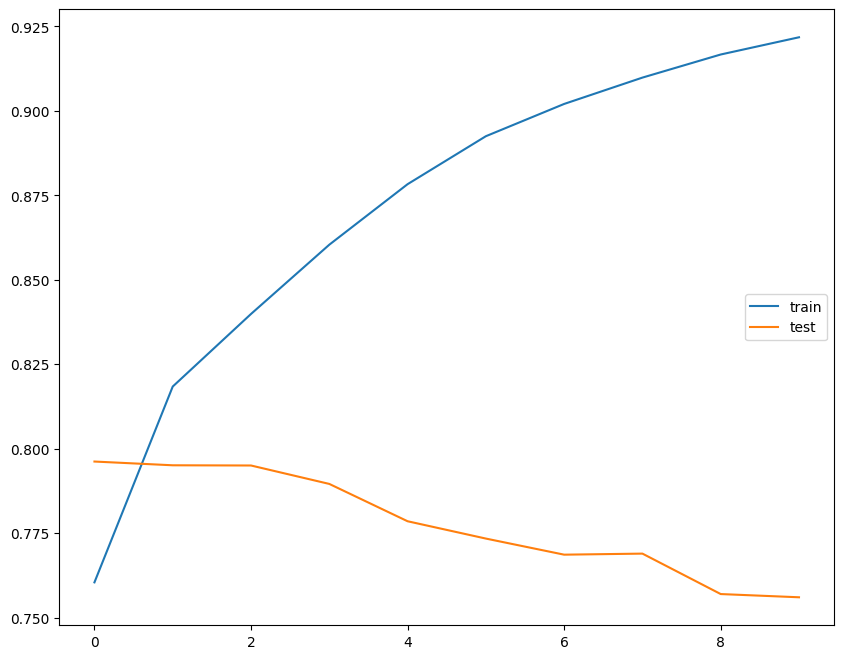

In [99]:
plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='right')

plt.show()

In [100]:
loss, accuracy = encoder_model.evaluate(X_val, y_val)

2000/2000 [==============================] - 10s 5ms/step - loss: 0.7819 - accuracy: 0.7560


In [101]:
print(loss, accuracy)

0.7819225192070007 0.7560312747955322


In [102]:
y_pred = encoder_model.predict(X_val)

2000/2000 [==============================] - 7s 4ms/step


In [103]:
y_pred.shape

(64000, 1)

Convert the probabilities to the predicted labels

In [104]:
y_pred = (y_pred >= 0.5).astype(int)

In [105]:
y_pred.sum()

29484

In [106]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.79      0.77     32066
           1       0.78      0.72      0.75     31934

    accuracy                           0.76     64000
   macro avg       0.76      0.76      0.76     64000
weighted avg       0.76      0.76      0.76     64000



In [107]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.7559512567614008


In [108]:
accuracy_score(y_val, y_pred)

0.75603125

### BERT pre-trained model

The BERT pretrained model provides a custom preprocessor which will tokenize and prepare the data, so we want to preserve the original tweet text as strings in the data.

In [109]:
X_train, X_val, y_train, y_val = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [110]:
for i in range(20):
  print(X_train[i], y_train.iloc[i])

i miss talking to you 0
i love the way you love but hate the way im supposed to love you back 0
you r welcome here anytime 1
wrong john wink tehe and im sry i cant make it 0
when yall comin ova wink how are you i miss you guys 1
got my little black dress on and im going out for lunch 1
i mean people yeah got confuse too 0
is in the crowd at cherry blossom festival in japtown oh food everywhere 1
its a rainy day in rome 0
our newest family member oscar norwegian forest cat 1
online at school my classmate is a creepy fucking stalker i hate him 0
those puppy millers will keep trainers in biz for a long time best of luck patience amp cheese with your boy 0
ill get alot of sewing done today no tv the bulb burned out so waiting for a new one hopefully in a couple of days 0
the betty finale was so touching poor daniel and mark wonder who was in wilheminas apartment though 0
i love ur tattoo quotthe parent trapquot is my fave movie of all time 1
c nh ch ang m 0
bravo a man with a plan 1
you ar

Select the specific BERT model. 

In [111]:
# Thanks to https://www.tensorflow.org/text/tutorials/classify_text_with_bert
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


Tensorflow-text version must match the tensorflow version

In [112]:
tf.__version__

'2.12.0'

In [113]:
# Dependency of the preprocssing for BERT inputs
!pip install "tensorflow-text==2.12.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.1 MB/s eta 0:00:00


In [114]:
import tensorflow_text as text

In [115]:
!pip install -q tf.models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 17.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 51.6 MB/s eta 0:00:00


In [117]:
import functools
import os
import shutil

import tensorflow_hub as hub
from official.nlp import optimization  # to create AdamW optimizer

tf.get_logger().setLevel('ERROR')

In [118]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [119]:
test_text = X_train[0]
text_preprocessed = bert_preprocess_model([test_text])

print(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

i miss talking to you
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 1045 3335 3331 2000 2017  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [120]:
test_text = X_train[1]
text_preprocessed = bert_preprocess_model([test_text])

print(test_text)
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

i love the way you love but hate the way im supposed to love you back
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101  1045  2293  1996  2126  2017  2293  2021  5223  1996  2126 10047]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [121]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [122]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9783648   0.9671675  -0.07663714  0.17565365  0.7512241   0.5262315
  0.69633245 -0.98700315 -0.4942095  -0.9998692   0.06384287 -0.96004385]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[ 0.0140086  -0.4354632   1.2572222  ... -1.4829783   0.6828621
   0.59009814]
 [ 0.7085488   0.39691657  0.36628348 ... -1.1383668   0.53740966
  -0.04683883]
 [ 0.72564626  0.10178615  0.21924908 ... -1.459066   -0.5589173
  -0.45191872]
 ...
 [-0.02621409  0.11257612 -1.6822671  ... -1.3854194   0.6136715
   0.10328133]
 [-1.7394716  -1.262528    0.17053162 ...  0.18295574  0.2095122
   0.4478798 ]
 [-0.26178575 -0.3784606   0.20619042 ... -0.52133125  1.593513
  -0.6186781 ]]


In [123]:
def build_classifier_model():
  text_input = layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = layers.Dense(256, activation='relu', name='dense-256')(net)
  #net = layers.Dense(128, activation='relu', name='dense-128')(net)
  net = layers.Dropout(0.1)(net)
  net = layers.Dense(32, activation='relu', name='dense-32')(net)
  net = layers.Dropout(0.1)(net)
  net = layers.Dense(1, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [131]:
BATCH_SIZE = 16
EPOCHS = 3

In [132]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant([test_text]))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6039493]], shape=(1, 1), dtype=float32)


In [133]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [134]:
steps_per_epoch = X_train.shape[0] / BATCH_SIZE
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [135]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=['accuracy'])

In [136]:
classifier_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [137]:
history = classifier_model.fit(x=X_train,
                               y=y_train,
                               epochs=EPOCHS,
                               batch_size=BATCH_SIZE,
                               validation_data=(X_val, y_val))

Epoch 1/3
16000/16000 [==============================] - 2178s 136ms/step - loss: 0.4538 - accuracy: 0.7863 - val_loss: 0.3972 - val_accuracy: 0.8222
Epoch 2/3
16000/16000 [==============================] - 2164s 135ms/step - loss: 0.3724 - accuracy: 0.8376 - val_loss: 0.3901 - val_accuracy: 0.8305
Epoch 3/3
16000/16000 [==============================] - 2222s 139ms/step - loss: 0.3255 - accuracy: 0.8627 - val_loss: 0.4101 - val_accuracy: 0.8312


Evaluate

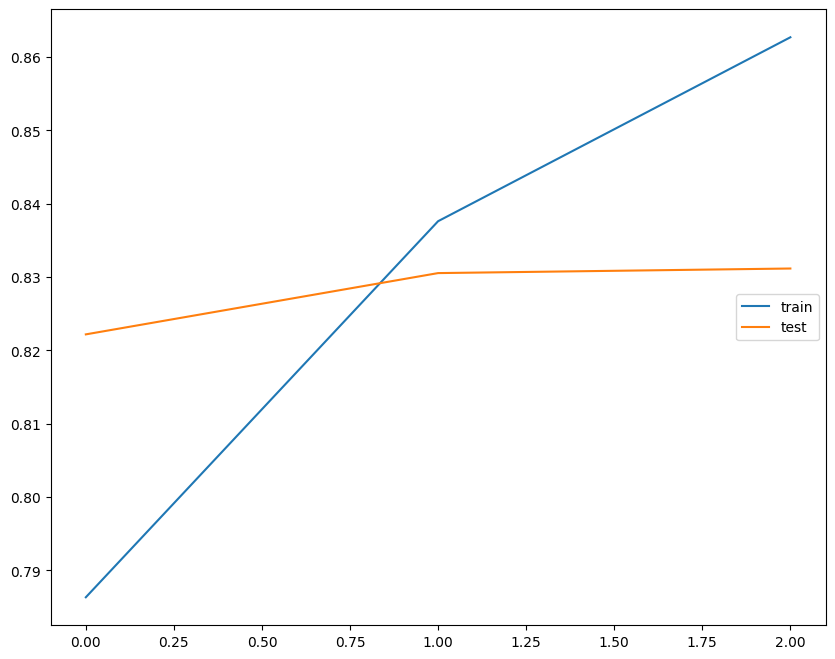

In [138]:
plt.figure(figsize=(10, 8))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'], loc='right')

plt.show()

In [139]:
loss, accuracy = classifier_model.evaluate(X_val, y_val)

2000/2000 [==============================] - 240s 120ms/step - loss: 0.4101 - accuracy: 0.8312


In [140]:
y_pred = classifier_model.predict(X_val)

2000/2000 [==============================] - 224s 112ms/step


In [141]:
y_pred = (y_pred >= 0.5).astype(int)

In [142]:
print(loss, accuracy)

0.4101146459579468 0.8311718702316284


In [143]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.85      0.83     32066
           1       0.84      0.81      0.83     31934

    accuracy                           0.83     64000
   macro avg       0.83      0.83      0.83     64000
weighted avg       0.83      0.83      0.83     64000



In [144]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

In [145]:
accuracy_score(y_val, y_pred)

0.831171875